In [1]:
import pandas as pd
import numpy as np
import folium
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load the dataset
data = pd.read_parquet("C:/Users/Axl Wynants/Desktop/Datathon_2024-main/Data/interventions_bxl.parquet.gzip").drop_duplicates()

# For Permanence Locations
data['latitude_permanence']= data['latitude_permanence'].apply(lambda x: float(str(x)[:2] + '.' + str(x)[2:]))
data['longitude_permanence']= data['longitude_permanence'].apply(lambda x: float(str(x)[:1] + '.' + str(x)[1:]))

# For Intervention Locations
data['latitude_intervention']= data['latitude_intervention'].astype(int).apply(lambda x: float(str(x)[:2] + '.' + str(x)[2:]))
data['longitude_intervention']= data['longitude_intervention'].astype(int).apply(lambda x: float(str(x)[:1] + '.' + str(x)[1:]))


# Filter the dataset to only include relevant columns
relevant_data = data[['latitude_permanence', 'longitude_permanence', 
                      'latitude_intervention', 'longitude_intervention', 
                      'vector_type', 'waiting_time']].dropna()

relevant_data = relevant_data[relevant_data['longitude_intervention'] > 4]


aed_bxl = pd.read_csv('C:/Users/Axl Wynants/Desktop/Datathon_2024-main/Data/aed_bxlcoord.csv')


In [6]:
# Concatenate permanence and intervention locations horizontally
locations = pd.concat([relevant_data[['latitude_permanence', 'longitude_permanence']],
                       relevant_data[['latitude_intervention', 'longitude_intervention']]], axis=1)

locations = locations[locations['longitude_intervention'] > 4]

# Convert DataFrame to numpy array
X = locations.values

In [7]:
# Compute epsilon using a heuristic based on the distance between points
min_pts = 5  # Minimum number of points in a cluster
epsilon = np.sqrt(2) * np.std(X)  # Heuristic for epsilon

# Apply DBSCAN clustering algorithm
dbscan = DBSCAN(eps=0.01, min_samples=10, metric='euclidean').fit(X)

# Get the cluster labels
labels = dbscan.labels_

# Find the optimal AED locations as the centroids of the clusters with the lowest waiting time
unique_labels = np.unique(labels)
aed_locations = []
for label in unique_labels:
    if label != -1:  # Ignore noise points
        cluster_points = X[labels == label]
        cluster_waiting_times = relevant_data.iloc[labels == label]['waiting_time']
        weighted_waiting_time = np.sum(cluster_waiting_times) / len(cluster_waiting_times)
        centroid = np.mean(cluster_points, axis=0)
        aed_locations.append((centroid, weighted_waiting_time))

# Sort AED locations based on weighted waiting time
aed_locations.sort(key=lambda x: x[1])

# Center coordinates for Brussels
brussels_center = (50.8503, 4.3517)

# Initialize the map
m = folium.Map(location=brussels_center)

# Add markers for AED locations with custom icon
unique_locations = set()  # Keep track of unique locations added
locations_added = 0  # Track the number of unique locations added
for locations, _ in aed_locations:
    for i in range(0, len(locations), 2):
        lat, lon = locations[i], locations[i + 1]
        if (lat, lon) in zip(aed_bxl['latitude'], aed_bxl['longitude']):
            print(f"Skipping location {lat}, {lon} as it's already in the dataframe")
            continue  # Skip this location if it's already present in the dataframe
        if (lat, lon) in unique_locations:
            continue  # Skip this location if it's already added
        folium.Marker(location=(lat, lon), popup=f"AED Location {locations_added + 1}",
                      icon=folium.CustomIcon('C:/Users/Axl Wynants/Desktop/Datathon_2024-main/AED.png', icon_size=(32, 32))).add_to(m)
        unique_locations.add((lat, lon))
        locations_added += 1
        if locations_added == 5:  # Stop after adding 5 unique locations
            break
    if locations_added == 5:  # Stop outer loop after adding 5 unique locations
        break


# Save the map to an HTML file
m.save("dbscan_aed_locations_map.html")

           count        mean         std   min    25%   50%    75%     max
Cluster                                                                   
0         8309.0   14.255145   55.315640   1.0   8.00  10.0  13.00  1459.0
1         3751.0   22.545721   91.484384   1.0   9.00  12.0  20.00  1484.0
2         2097.0   19.940868   72.324922   1.0   9.00  12.0  18.00  1469.0
3         7367.0   17.543505   71.610201   0.0   8.00  10.0  15.00  1472.0
4        11813.0   17.596885   75.147160   1.0   8.00  11.0  15.00  1478.0
5         2956.0   20.722598   75.751443   1.0  10.00  13.0  19.00  1517.0
6         9577.0   17.904981   79.429353   1.0   8.00  10.0  14.00  1486.0
7         7269.0   18.325079   59.945362   1.0  10.00  12.0  17.00  1494.0
8        12432.0   18.376126   75.633128   0.0   9.00  11.0  16.00  1472.0
9         1284.0   17.938474   42.837183   1.0   9.00  12.0  17.00  1446.0
10        8465.0   19.344714   87.103760   0.0   9.00  11.0  15.00  1485.0
11        4175.0   18.354

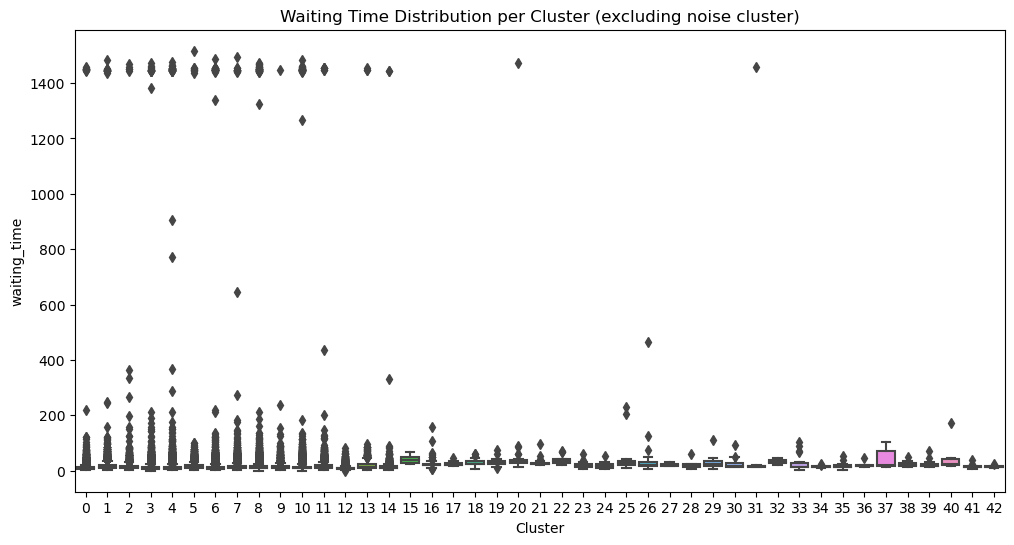

In [8]:
relevant_data['Cluster'] = labels

# Filter out the noise cluster (-1)
relevant_data_filtered = relevant_data[relevant_data['Cluster'] != -1]

relevant_data_filtered = relevant_data_filtered[relevant_data_filtered['waiting_time'] < 100000]

# Analyze waiting time per cluster (excluding noise cluster)
cluster_statistics_filtered = relevant_data_filtered.groupby('Cluster')['waiting_time'].describe()

# Print or visualize cluster statistics (excluding noise cluster)
print(cluster_statistics_filtered)

# Visualize Waiting Time Distributions per Cluster (excluding noise cluster)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='waiting_time', data=relevant_data_filtered)
plt.title('Waiting Time Distribution per Cluster (excluding noise cluster)')
plt.show()

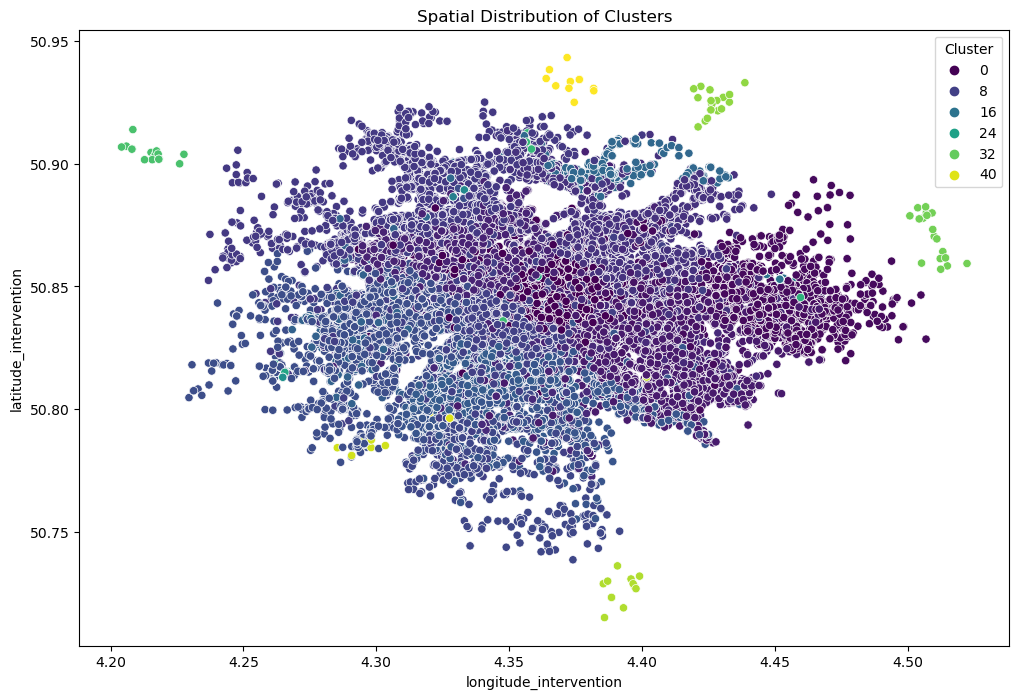

In [9]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude_intervention', y='latitude_intervention', hue='Cluster', palette='viridis', data=relevant_data_filtered)
plt.title('Spatial Distribution of Clusters')
plt.show()

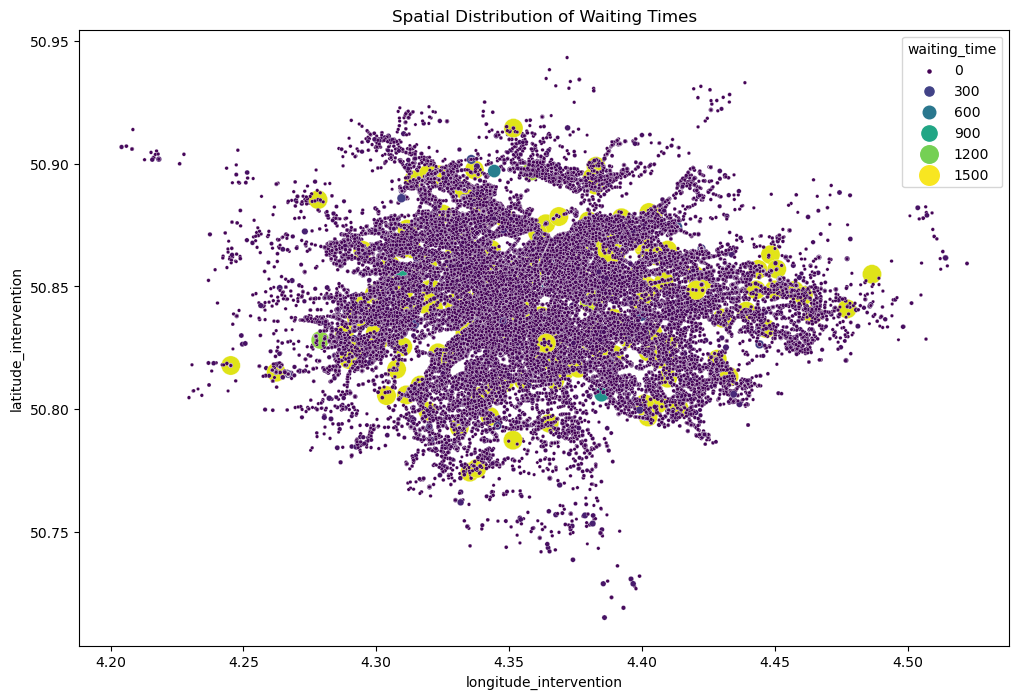

In [10]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude_intervention', y='latitude_intervention', hue='waiting_time', palette='viridis', size='waiting_time', sizes=(5, 200), data=relevant_data_filtered)
plt.title('Spatial Distribution of Waiting Times')
plt.show()